In [5]:
!pip install ray

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


876/876 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0195 - val_loss: 0.0135
Epoch 2/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0145 - val_loss: 0.0135
Epoch 3/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0138 - val_loss: 0.0135
Epoch 4/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0134 - val_loss: 0.0135
Epoch 5/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0131 - val_loss: 0.0135
Epoch 6/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0133 - val_loss: 0.0135
Epoch 7/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0131 - val_loss: 0.0135
Epoch 8/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0132 - val_loss: 0.0135
Epoch 9/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0132 - val_loss: 0.0135
Epoch 10/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0133 - val_loss: 0.0135


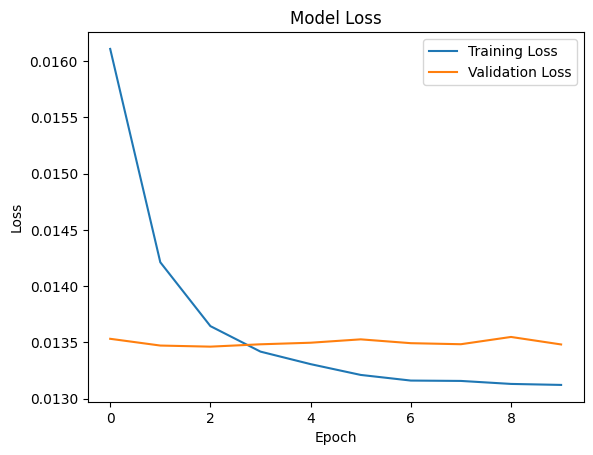

In [17]:
import pandas as pd
import numpy as np
import time
import os
import ray
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt

np.random.seed(101)

# Initialize Ray only if it's not already running
if not ray.is_initialized():
    ray.init(ignore_reinit_error=True)

def load_data(file_path, sample_fraction=0.2):
    """ Load data and take a fraction of the dataset to speed up training. """
    df = pd.read_csv(file_path)
    return df.sample(frac=sample_fraction, random_state=101)  # Reduce dataset to 20%

def downsample(df, step=5):
    """ Keep every Nth row to further reduce dataset size. """
    return df.iloc[::step, :]

def encode_categorical(df, categorical_cols):
    encoder = LabelEncoder()
    for col in categorical_cols:
        df[col] = encoder.fit_transform(df[col].astype(str))  # Convert to string before encoding
    return df

def merge_datasets(telemetry, errors, machines, failures, maintenance):
    df = telemetry
    df = df.merge(failures, on=['datetime', 'machineID'], how='left')
    df = df.merge(errors, on=['datetime', 'machineID'], how='left')
    df = df.merge(maintenance, on=['datetime', 'machineID'], how='left')
    df = df.merge(machines, on=['machineID'], how='left')
    df.fillna(0, inplace=True)  # Replace NaNs with 0

    # Identify categorical columns
    categorical_cols = ['comp', 'errorID', 'failure', 'model']
    df = encode_categorical(df, categorical_cols)

    return df

def scale_data(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df.drop(['machineID', 'datetime'], axis=1))
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns.drop(['machineID', 'datetime']))
    return scaled_df

def generate_sequences(data, seq_length=25, future_target=1):
    """ Reduce sequence length to speed up training. """
    X, y = [], []
    for i in range(len(data) - seq_length - future_target):
        X.append(data.iloc[i:i + seq_length].values)
        y.append(data.iloc[i + seq_length + future_target, 0])
    return np.array(X), np.array(y)

def build_lstm_model(input_shape, lstm_units=50, dropout_rate=0.2):
    """ Reduce LSTM units to improve speed. """
    model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(lstm_units // 2, return_sequences=False),
        Dropout(dropout_rate),
        Dense(1)
    ])
    return model

def train_lstm_model(model, X_train, y_train, batch_size=32, epochs=10):
    """ Reduce batch size and epochs for faster training. """
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    return model, history

def main():
    # Load datasets with reduced size
    telemetry = load_data('PdM_telemetry.csv')
    errors = load_data('PdM_errors.csv')
    machines = load_data('PdM_machines.csv')
    failures = load_data('PdM_failures.csv')
    maintenance = load_data('PdM_maint.csv')

    # Merge datasets
    df = merge_datasets(telemetry, errors, machines, failures, maintenance)
    df = downsample(df, step=5)  # Downsample to further reduce size

    # Scale data
    scaled_data = scale_data(df)

    # Generate sequences
    X_train, y_train = generate_sequences(scaled_data, seq_length=25, future_target=1)

    # Build and train LSTM model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_lstm_model(input_shape)
    model, history = train_lstm_model(model, X_train, y_train, batch_size=32, epochs=10)

    # Plot training history
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
    ray.shutdown()


In [31]:
import gradio as gr  # Import Gradio
import pandas as pd
import numpy as np
import pickle
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from fastapi import FastAPI, UploadFile, File, HTTPException
import threading
import uvicorn
from google.colab import output
import nest_asyncio

# Apply nest_asyncio to avoid event loop issues in Jupyter/Colab
nest_asyncio.apply()

# Initialize FastAPI app
app = FastAPI()

# Global variables
model = None
scaler = MinMaxScaler()
data = None
feature_names = []

# Falcon-7B chatbot simulation
def falcon_chatbot(query):
    return f"[Falcon-7B Response] Simulated answer to: {query}"

# Upload dataset
@app.post("/upload/")
async def upload_file(file: UploadFile = File(...)):
    global data, feature_names
    try:
        df = pd.read_csv(file.file)
        df = df.sample(frac=0.1, random_state=101)
        df = df.fillna(0).drop(columns=['machineID', 'datetime'], errors='ignore')
        data = df
        feature_names = list(df.columns)

        with open("feature_names.pkl", "wb") as f:
            pickle.dump(feature_names, f)

        return {"message": "File uploaded successfully", "columns": feature_names}
    except Exception as e:
        raise HTTPException(status_code=400, detail=str(e))

# Train LSTM model
@app.post("/train/")
def train_model():
    global model, data, scaler
    if data is None:
        raise HTTPException(status_code=400, detail="No dataset uploaded")

    # Data Preprocessing
    df = data
    scaled_data = scaler.fit_transform(df)

    # Save scaler
    with open("scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)

    # Generate sequences
    def generate_sequences(data, seq_length=50, future_target=1):
        X, y = [], []
        for i in range(len(data) - seq_length - future_target):
            X.append(data[i:i + seq_length])
            y.append(data[i + seq_length + future_target, 0])
        return np.array(X), np.array(y)

    X_train, y_train = generate_sequences(scaled_data)

    # Reduce dataset size for faster training
    X_train, y_train = X_train[:500], y_train[:500]

    # Build model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(25, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
    model.save("lstm_model.h5")

    return {"message": "Model trained and saved"}

# Predict with LSTM model
@app.post("/predict/")
def predict(column_name: str, input_value: float):
    global model, data

    try:
        if model is None:
            model = load_model("lstm_model.h5")

        if data is None:
            raise HTTPException(status_code=400, detail="No dataset uploaded")

        if column_name not in feature_names:
            raise HTTPException(status_code=400, detail="Invalid column name")

        # Load scaler
        with open("scaler.pkl", "rb") as f:
            scaler = pickle.load(f)

        # Create input array with mean values
        input_array = np.zeros((1, len(feature_names)))
        dataset_means = data.mean().to_dict()

        for i, col in enumerate(feature_names):
            input_array[0, i] = dataset_means.get(col, 0)  # Default to mean

        # Update selected column with user input
        input_array[0, feature_names.index(column_name)] = float(input_value)

        # Scale input
        scaled_input = scaler.transform(input_array)

        # ✅ Fix: Reshape input to match LSTM's expected shape
        sequence_length = 50  # Update this based on your training data
        reshaped_input = np.reshape(scaled_input, (1, sequence_length, len(feature_names)))

        # Predict
        prediction = model.predict(reshaped_input)

        return {"prediction": float(prediction[0][0])}

    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Prediction error: {str(e)}")

# Falcon-7B chatbot API
@app.get("/chat/")
def chat(query: str):
    return {"response": falcon_chatbot(query)}

# Start FastAPI server in a separate thread
def start_server():
    uvicorn.run(app, host="0.0.0.0", port=8000, log_level="error")

threading.Thread(target=start_server, daemon=True).start()
output.serve_kernel_port_as_window(8000)

# --- GRADIO UI ---

# Upload function for Gradio
def upload_ui(file):
    global data, feature_names
    try:
        df = pd.read_csv(file.name)
        df = df.sample(frac=0.1, random_state=101)
        df = df.fillna(0).drop(columns=['machineID', 'datetime'], errors='ignore')
        data = df
        feature_names = list(df.columns)

        with open("feature_names.pkl", "wb") as f:
            pickle.dump(feature_names, f)

        return "✅ File uploaded successfully!", gr.update(choices=feature_names)
    except Exception as e:
        return f"❌ Error: {str(e)}", gr.update(choices=[])

# Train function for Gradio
def train_ui():
    result = train_model()
    return result["message"]

# Predict function for Gradio
def predict_ui(column_name, input_value):
    try:
        input_value = float(input_value)
        result = predict(column_name, input_value)
        return f"Prediction: {result['prediction']}"
    except Exception as e:
        return f"❌ Error: {str(e)}"

# Chatbot function for Gradio
def chat_ui(query):
    return falcon_chatbot(query)

# Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("## 🚀 AI-Powered System (FastAPI + Gradio)")

    with gr.Tab("📂 Upload Dataset"):
        file_input = gr.File(label="Upload CSV File")
        upload_btn = gr.Button("Upload")
        upload_output = gr.Textbox()
        column_dropdown = gr.Dropdown(label="Select Feature Column", choices=[], interactive=True)
        upload_btn.click(upload_ui, inputs=file_input, outputs=[upload_output, column_dropdown])

    with gr.Tab("📊 Train Model"):
        train_btn = gr.Button("Train Model")
        train_output = gr.Textbox()
        train_btn.click(train_ui, outputs=train_output)

    with gr.Tab("🤖 Predict"):
        input_value = gr.Textbox(label="Enter Value")
        predict_btn = gr.Button("Predict")
        predict_output = gr.Textbox()
        predict_btn.click(predict_ui, inputs=[column_dropdown, input_value], outputs=predict_output)

    with gr.Tab("💬 Falcon Chatbot"):
        chat_input = gr.Textbox(label="Ask Falcon-7B")
        chat_btn = gr.Button("Chat")
        chat_output = gr.Textbox()
        chat_btn.click(chat_ui, inputs=chat_input, outputs=chat_output)

# Launch Gradio interface
demo.launch(share=True)


Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

ERROR:    [Errno 98] error while attempting to bind on address ('0.0.0.0', 8000): address already in use
ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-284' coro=<Server.serve() done, defined at /usr/local/lib/python3.11/dist-packages/uvicorn/server.py:68> exception=SystemExit(1)>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/server.py", line 163, in startup
    server = await loop.create_server(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/asyncio/base_events.py", line 1536, in create_server
    raise OSError(err.errno, msg) from None
OSError: [Errno 98] error while attempting to bind on address ('0.0.0.0', 8000): address already in use

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in r

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6ab7ac088788b237d4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [27]:
df = pd.read_csv("/content/PdM_telemetry.csv")
print(df.columns)  # Debugging


Index(['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration'], dtype='object')
